In [1]:
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.datasets import make_moons
from scipy.stats import multivariate_normal

In [2]:
# --- Data Generation ---
np.random.seed(42)
n_samples = 2000
means = np.array([[-1, -1], [1, 1]])
covariances = [np.array([[1, 0.5], [0.5, 1]]), np.array([[1, -0.5], [-0.5, 1]])]
proportions = [0.5, 0.5]
n_clusters = len(means)

# Generate data
data = []
labels = []
for i, (mean, cov, prop) in enumerate(zip(means, covariances, proportions)):
    n = int(prop * n_samples)
    cluster_data = np.random.multivariate_normal(mean, cov, n)
    data.append(cluster_data)
    labels += [i] * n
data = np.vstack(data)
labels = np.array(labels)

In [3]:
# --- Plotting Utility ---
def plot_clusters(data, labels, centroids=None, title=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    if labels.ndim > 1:
        c=  labels[:,0]
    else:
        c = labels
    ax.scatter(data[:, 0], data[:, 1], c=c, cmap="coolwarm", s=10)
    if centroids is not None:
        ax.scatter(centroids[:, 0], centroids[:, 1], s=300, c="black", marker="X")
    if title is not None:
        ax.set_title(title)

def plot_gaussian_ellipses(means, covariances, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for mean, cov in zip(means, covariances):
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues)
        ellipse = Ellipse(
            xy=mean,
            width=width,
            height=height,
            angle=angle,
            edgecolor="black",
            fc="None",
            lw=2,
        )
        ax.add_patch(ellipse)

In [4]:
# --- KMeans Class ---
class KMeansCustom:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters

    def initialize_centroids(self, data):
        n_samples = data.shape[0]
        indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = data[indices]

    def assign_clusters(self, data):
        """
        Assign each point to the nearest centroid.
        """

        distances = np.zeros((data.shape[0], self.n_clusters))
        for c in range(self.n_clusters): 
            distances[:, c] = np.linalg.norm(data - self.centroids[c], axis=1)
        labels = np.argmin(distances, axis=1)

        return labels

    def update_centroids(self, data, labels):
        """
        Update centroids as the mean of all points assigned to each cluster.
        """
        new_centroids = np.zeros((self.n_clusters, data.shape[1]))
        for c in range(self.n_clusters):
            new_centroids[c,:] = np.mean(data[labels==c])
        return new_centroids

    def fit(self, data, iterations_to_store=[0, 1, 2, 5, 10, 20]):
        self.initialize_centroids(data)
        self.stored_params = {}
        for i in range(max(iterations_to_store) + 1):
            labels = self.assign_clusters(data)
            new_centroids = self.update_centroids(data, labels)
            if i in iterations_to_store:
                self.stored_params[i] = {
                    "centroids": self.centroids.copy(),
                    "labels": labels.copy(),
                }
            self.centroids = new_centroids

    def predict(self, data):
        return self.assign_clusters(data)

In [5]:
# --- EM Class ---
class EMGMM:
    def __init__(self, n_components):
        self.n_components = n_components

    def initialize_params(self, data):
        n_samples, n_features = data.shape
        self.means = data[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = np.array([np.eye(n_features)] * self.n_components)
        self.weights = np.ones(self.n_components) / self.n_components

    def e_step(self, data):
        """
        Compute responsibilities (soft assignments) for each cluster.
        """
        numerator = np.zeros((data.shape[0], self.n_components))
        for k in range(self.n_components):
            numerator[:, k] = self.weights[k] * multivariate_normal.pdf(data, mean=self.means[k], cov=self.covariances[k])
        denominator = np.sum(numerator, axis=1)

        responsibilities = np.zeros((data.shape[0], self.n_components))
        for p in range(data.shape[0]):
            responsibilities[p, :] = numerator[p,:]/denominator[p]
        
        return responsibilities

    def m_step(self, data, responsibilities):
        """
        Update means, covariances, and weights based on responsibilities.
        """
        N_k = np.sum(responsibilities, axis=0)  # Number of data points assigned to each cluster
        N = data.shape[0]  # Total number of data points
        
        # Update the weights (mixing coefficients)
        self.weights = N_k / N
        
        # Update the means
        self.means = np.matmul(responsibilities.T, data) / N_k[:, np.newaxis]
        
        # Update the covariances
        self.covariances = np.zeros((self.n_components, data.shape[1], data.shape[1]))  # Initialize the covariance matrices
        for k in range(self.n_components):
            diff = data - self.means[k]  # Difference between data points and the mean
            weighted_diff = responsibilities[:, k][:, np.newaxis] * diff  # Weighted difference
            self.covariances[k] = np.matmul(weighted_diff.T, diff) / N_k[k]  # Covariance matrix

    def multivariate_gaussian(self, data, mean, cov):
        """
        Compute the multivariate Gaussian probability density.
        """
        return multivariate_normal.pdf(data, mean=mean, cov=cov)

    def fit(self, data, iterations_to_store=[0, 1, 2, 5, 10, 20]):
        self.initialize_params(data)
        self.stored_params = {}
        for i in range(max(iterations_to_store) + 1):
            responsibilities = self.e_step(data)
            self.m_step(data, responsibilities)
            if i in iterations_to_store:
                self.stored_params[i] = {
                    "means": self.means.copy(),
                    "covariances": self.covariances.copy(),
                    "responsibilities": responsibilities.copy(),
                }

    def predict(self, data):
        responsibilities = self.e_step(data)
        return np.argmax(responsibilities, axis=1)

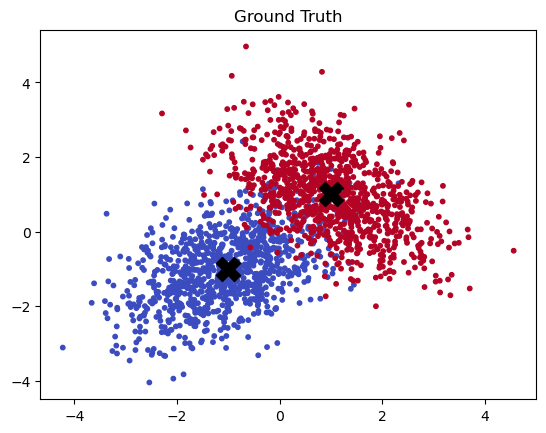

In [6]:
# --- Example Usage ---
# Plot initial data
plot_clusters(data, labels, means, title="Ground Truth")

In [12]:
# Run k-means
kmeans = KMeansCustom(n_clusters=n_clusters)
kmeans.fit(data)
kmeans_labels = kmeans.predict(data)

# Metrics
ari_kmeans = adjusted_rand_score(labels, kmeans_labels)
print(f"k-means ARI: {ari_kmeans:.3f}")

k-means ARI: 0.702


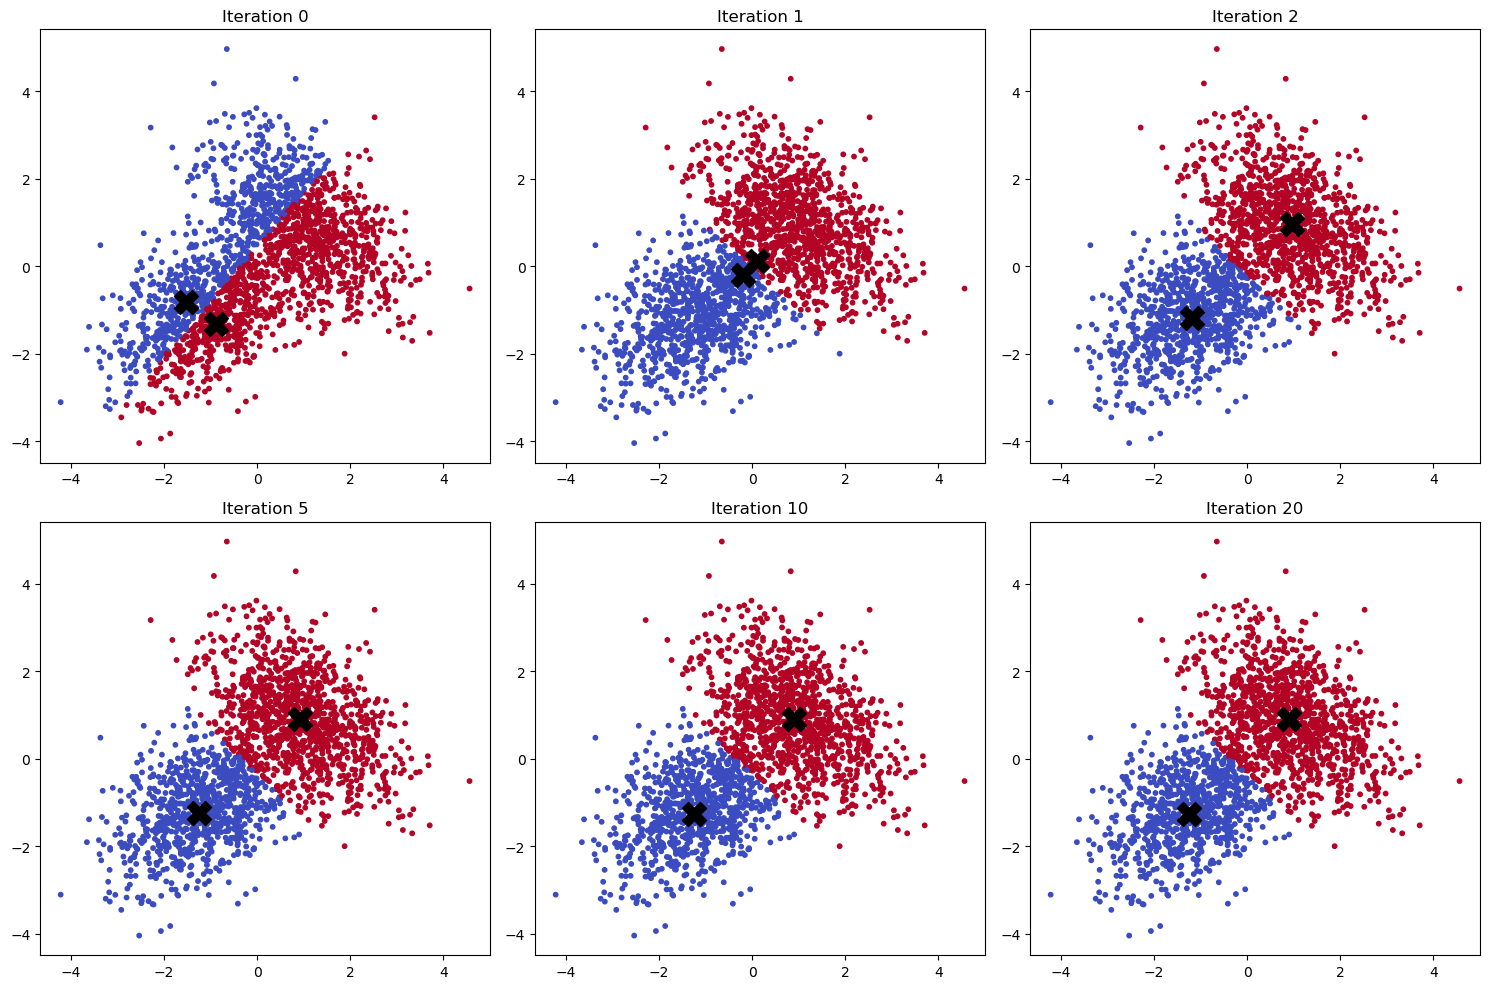

In [13]:
iterations = [0, 1, 2, 5, 10, 20]
# Plot assignments at specified iterations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, i in zip(axes.flatten(), iterations):
    responsibilities = kmeans.stored_params[i]["labels"]
    em_centroids = kmeans.stored_params[i]["centroids"]
    plot_clusters(data, responsibilities, em_centroids, ax=ax)
    ax.set_title(f"Iteration {i}")
plt.tight_layout()

In [17]:
# Run EM
em = EMGMM(n_components=n_clusters)
em.fit(data)
em_labels = em.predict(data)

# Metrics
ari_em = adjusted_rand_score(labels, em_labels)
print(f"EM ARI: {ari_em:.3f}")

EM ARI: 0.771


In [ ]:
iterations = [0, 1, 2, 5, 10, 20]
# Plot assignments at specified iterations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, i in zip(axes.flatten(), iterations):
    responsibilities = em.stored_params[i]["responsibilities"]
    cov = em.stored_params[i]["covariances"]
    em_centroids = em.stored_params[i]["means"]
    plot_clusters(data, responsibilities, em_centroids, ax=ax)
    plot_gaussian_ellipses(em_centroids, cov, ax=ax)
    ax.set_title(f"Iteration {i}")
plt.tight_layout()

In [ ]:
# --- Q5: The Effect of Overestimating Clusters ---

# TODO: # Fill in the code to run k-means and EM with different values of k and plot the results and ARI scores.

k_values = [2, 4, 8]

def ari_score_per_cluster(k_values, custom_model, data, labels):
    scores = []
    for k in k_values:
        model = custom_model(k)
        model.fit(data)
        pred_labels = model.predict(data)
        score = adjusted_rand_score(labels, pred_labels)
        scores.append(score)
    return scores

ari_kmeans = ari_score_per_cluster(k_values, KMeansCustom, data, labels)
ari_gmm = ari_score_per_cluster(k_values, EMGMM, data, labels)

plt.figure(figsize=(8, 6))
plt.plot(k_values, ari_kmeans, marker='o', label='K-Means', color='b')
plt.plot(k_values, ari_gmm, marker='s', label='EM (GMM)', color='r')

plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Adjusted Rand Index', fontsize=12)
plt.title('ARI Scores for K-Means and EMGMM', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# --- Q6: Non-Circular Clusters (make_moons) ---
def generate_moons_data():
    data, labels = make_moons(n_samples=2000, noise=0.1, random_state=42)
    return data, labels

moons_data, moons_labels = generate_moons_data()
plot_clusters(moons_data, moons_labels, title="Non-Circular Clusters (Moons)")

# TODO: # Fill in the code to run k-means and EM on the moons dataset for k = 2 and 4 clusters and plot the results

# Run EM
em = EMGMM(n_components=4)
em.fit(moons_data)
em_labels = em.predict(moons_data)

# Metrics
ari_em = adjusted_rand_score(moons_labels, em_labels)
print(f"EM ARI: {ari_em:.3f}")

iterations = [0, 1, 2, 5, 10, 20]
# Plot assignments at specified iterations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, i in zip(axes.flatten(), iterations):
    responsibilities = em.stored_params[i]["responsibilities"]
    cov = em.stored_params[i]["covariances"]
    em_centroids = em.stored_params[i]["means"]
    plot_clusters(moons_data, responsibilities, em_centroids, ax=ax)
    plot_gaussian_ellipses(em_centroids, cov, ax=ax)
    ax.set_title(f"Iteration {i}")
plt.tight_layout()

In [ ]:
# Run k-means
kmeans = KMeansCustom(n_clusters=4)
kmeans.fit(moons_data)
kmeans_labels = kmeans.predict(moons_data)

# Metrics
ari_kmeans = adjusted_rand_score(moons_labels, kmeans_labels)
print(f"k-means ARI: {ari_kmeans:.3f}")
iterations = [0, 1, 2, 5, 10, 20]
# Plot assignments at specified iterations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, i in zip(axes.flatten(), iterations):
    responsibilities = kmeans.stored_params[i]["labels"]
    em_centroids = kmeans.stored_params[i]["centroids"]
    plot_clusters(moons_data, responsibilities, em_centroids, ax=ax)
    ax.set_title(f"Iteration {i}")
plt.tight_layout()